In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from os import listdir
import glob
import sncosmo
from ipywidgets import *
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')

from tabulate import tabulate #to export in table format
%matplotlib inline

In [2]:
kernel = 0.5 * (RBF(length_scale=3, length_scale_bounds=(1, 30)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5,0.5)))

# Read the files

In [3]:
# file data paths
data_path = "./data/sp/"
file_names = glob.glob(data_path+"*.dat")
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][10:]
print("Total files in path: ", len(file_names))

Total files in path:  2466


In [4]:
# auxiliar file 
sn_names = pd.read_csv("./data/list.dat",
                       header=None,
                       sep="\s+",
                       names=["name", "phase", "file_name"])
sn_names.head()

,name,phase,file_name
0,Test_SN0,-8.154,Test_SN0_0.dat
1,Test_SN0,-3.522,Test_SN0_1.dat
2,Test_SN0,17.959,Test_SN0_10.dat
3,Test_SN0,19.801,Test_SN0_11.dat
4,Test_SN0,19.816,Test_SN0_12.dat


In [5]:
names = sn_names["name"].unique()
print("Total number of sn files: ", len(names))

Total number of sn files:  171


# Training sample and simple graphs

In [6]:
w = widgets.Dropdown(
    options=names,
    value=names[0],
    description='SN name:',
    disabled=False,
)
display(w)

Dropdown(description='SN name:', options=('Test_SN0', 'Test_SN10', 'Test_SN11', 'Test_SN12', 'Test_SN13', 'Tes…

In [7]:
sn_spectra = glob.glob(data_path + w.value + "*.dat")

In [8]:
def spectra(i=0, plot=True):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    i = index of the element
    returns the wavelength, flux and flux error
    """
    if plot == True:
        data = sncosmo.read_lc(sn_spectra[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]
    else:
        data = sncosmo.read_lc(data_path+file_names[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]


## Spectra

In [9]:
# option list for jupyter lab widgets
optionslist = []
for i in range(0, len(sn_spectra)):
    optionslist.append(i)

def update_graph(i):
    """
    void function that updates a matplotlib graph
    """
    wave, flux, fluxe = spectra(i)
    plt.xlabel("$\lambda$  ($\AA$)")
    plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)")
    plt.plot(wave, flux, "k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Index: ', disabled=False)

widgets.interactive(update_graph,i=i) # to activate the interactive widget

interactive(children=(Dropdown(description='Index: ', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

## Monochromatic light curves

In [10]:
wave_number = 7000

time_lc = []
flux_lc = []

for i in range(0, len(sn_spectra)):
    wave, flux, fluxe = spectra(i)
    flux_lc.append(Spline1d(wave, flux,  k=1)(wave_number))
    time_lc.append(sn_names["phase"][sn_names["file_name"] == str(sn_spectra[i][10:])])

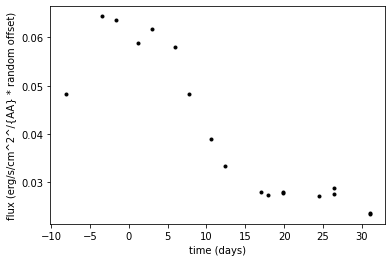

In [11]:
plt.plot(time_lc, flux_lc, "k.")
plt.xlabel("time (days)")
plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)");

## Training grid

In [12]:
"""
for i in range(0, len(file_names)):
    wave = spectra(i, plot=False)[0]
    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]
    plt.plot([phase,phase], [np.min(wave),np.max(wave)], 'k', linewidth=1)
    plt.xlabel("time (days)")
    plt.ylabel("$\lambda$ ($\AA$)")
    plt.xlim(-10, 50)
    plt.ylim(3500, 8500)
"""

'\nfor i in range(0, len(file_names)):\n    wave = spectra(i, plot=False)[0]\n    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]\n    plt.plot([phase,phase], [np.min(wave),np.max(wave)], \'k\', linewidth=1)\n    plt.xlabel("time (days)")\n    plt.ylabel("$\\lambda$ ($\\AA$)")\n    plt.xlim(-10, 50)\n    plt.ylim(3500, 8500)\n'

In [13]:
## Defining the grid
X_GRID = np.linspace(-10, 50, 61, dtype=int)
Y_GRID = np.linspace(3500, 8500, 501, dtype=int)

# Grid limits
print("time grid limits: ", np.min(X_GRID), ", ", np.max(X_GRID))
print("wavelenght grid limits: ", np.min(Y_GRID), ", ", np.max(Y_GRID))

time grid limits:  -10 ,  50
wavelenght grid limits:  3500 ,  8500


In [14]:
# split our data into a training and test dataset
np.random.seed(42)
sn_train, sn_test = train_test_split(names, test_size=0.2)
print(len(sn_train), len(sn_test))

136 35


In [40]:
def gaussian_process(wave, flux, error=True):
    """
    function that performs a gaussian process in a dataset of monochromatic light curves
    wave: Python list that gives the wavelenghts
    flux: np array that gives the flux
    error: binary variable to return or not the covariance in gaussian process regression
    
    return the corresponding gaussian process on data
    """
    # set the gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(wave, flux)
    if error==True:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=True) # return mean and covariance
    else:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=False) # return only mean     


In [16]:
def prepare_data_to_GP(wave):
    """
    function that convert a np array into a Python list for a gaussian process regression in SK-Learn
    wave: np array that gives the wavelenghts
    
    return the wavelenght in a correct format
    """
    temp_wave = [] # a new python list
    for ii in range(0, len(wave)):
        temp_wave.append([wave[ii]]) # correct SK-Learn format
    return temp_wave

In [17]:
def spectra_train(n_file):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    n_file: file name
    returns the wavelength, flux and flux error
    """
    data = sncosmo.read_lc(n_file, format="salt2")
    return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]

In [18]:
SPEC_TRAIN_FUN = []
SPEC_TRAIN_TIME = []
SPEC_TRAIN_MINMAX = []
for i in range(0, len(sn_train)):
    SPEC_TRAIN_FUN.append([]) # for spectra function
    SPEC_TRAIN_TIME.append([]) # for spectra time
    SPEC_TRAIN_MINMAX.append([]) # for min max spectra (in wavelenghts)

In [19]:
for i in range(0, len(sn_train)):
    sn_train_spectra = glob.glob(data_path + sn_train[i] + "_*.dat")
    for j in range(0, len(sn_train_spectra)):
        wave, flux, eflux = spectra_train(sn_train_spectra[j]) # to get wave, flux and flux error
        Nyquist_frequecy=int(len(wave)-1)/2
        cutoff=20 #angstroms
        #print(cutoff/Nyquist_frequecy)
        b, a = signal.butter(8, cutoff/Nyquist_frequecy, analog=False)
        filtered_flux=signal.filtfilt(b, a, flux, padlen=0)
        SPEC_TRAIN_FUN[i].append(Spline1d(wave, filtered_flux)) # to register the corresponding function
        SPEC_TRAIN_TIME[i].append(float(sn_names["phase"][sn_names["file_name"] == str(sn_train_spectra[j][10:])])) # to regirster the corresponding spectra time
        SPEC_TRAIN_MINMAX[i].append([float(np.min(wave)), float(np.max(wave))]) # to register min and max wavelength that function is available

In [27]:
SPEC_GRID = []
for i in range(0, len(sn_train)):
    SPEC_GRID.append([]) # loop for each supernovae in trainingfrom scipy import signal

In [28]:
for i in range(0, len(SPEC_GRID)):
    for j in range(0, len(Y_GRID)):
        SPEC_GRID[i].append([[], []]) # for each supernovae and for each wavelengh we fill with time and flux lists
#SPEC_GRID[0][1][0]  # first sn, second wave list order, time or flux

In [44]:
for i in range(0, len(sn_train)): # sn train index
    print(i+1, "/", len(sn_train))
    for j in range(0, len(Y_GRID)): #  grid index
        for k in range(0, len(SPEC_TRAIN_FUN[i])): #func index
            if SPEC_TRAIN_MINMAX[i][k][0] < Y_GRID[j] < SPEC_TRAIN_MINMAX[i][k][1]: # if it's inside the bounds
                SPEC_GRID[i][j][0].append([SPEC_TRAIN_TIME[i][k]]) # time
                SPEC_GRID[i][j][1].append(np.float(SPEC_TRAIN_FUN[i][k](Y_GRID[j]))) # flux

1 / 136
2 / 136
3 / 136
4 / 136
5 / 136

<ipython-input-44-a723f1e3694a>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SPEC_GRID[i][j][1].append(np.float(SPEC_TRAIN_FUN[i][k](Y_GRID[j]))) # flux



6 / 136
7 / 136
8 / 136
9 / 136
10 / 136
11 / 136
12 / 136
13 / 136
14 / 136
15 / 136
16 / 136
17 / 136
18 / 136
19 / 136
20 / 136
21 / 136
22 / 136
23 / 136
24 / 136
25 / 136
26 / 136
27 / 136
28 / 136
29 / 136
30 / 136
31 / 136
32 / 136
33 / 136
34 / 136
35 / 136
36 / 136
37 / 136
38 / 136
39 / 136
40 / 136
41 / 136
42 / 136
43 / 136
44 / 136
45 / 136
46 / 136
47 / 136
48 / 136
49 / 136
50 / 136
51 / 136
52 / 136
53 / 136
54 / 136
55 / 136
56 / 136
57 / 136
58 / 136
59 / 136
60 / 136
61 / 136
62 / 136
63 / 136
64 / 136
65 / 136
66 / 136
67 / 136
68 / 136
69 / 136
70 / 136
71 / 136
72 / 136
73 / 136
74 / 136
75 / 136
76 / 136
77 / 136
78 / 136
79 / 136
80 / 136
81 / 136
82 / 136
83 / 136
84 / 136
85 / 136
86 / 136
87 / 136
88 / 136
89 / 136
90 / 136
91 / 136
92 / 136
93 / 136
94 / 136
95 / 136
96 / 136
97 / 136
98 / 136
99 / 136
100 / 136
101 / 136
102 / 136
103 / 136
104 / 136
105 / 136
106 / 136
107 / 136
108 / 136
109 / 136
110 / 136
111 / 136
112 / 136
113 / 136
114 / 136
115 / 1

In [45]:
"""
Nsn = 30
Nspec = 100
TIME_TEMP = SPEC_GRID[Nsn][Nspec][0]
FLUX_TEMP = SPEC_GRID[Nsn][Nspec][1]

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(TIME_TEMP, FLUX_TEMP)
y_mean, y_cov = gp.predict(X_GRID[:, np.newaxis], return_cov=True) 

plt.plot(X_GRID, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_GRID, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)), alpha=0.5, color='k')
plt.scatter(TIME_TEMP, FLUX_TEMP, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlabel("time (days)")
plt.ylabel("flux (a.u)")
"""

'\nNsn = 30\nNspec = 100\nTIME_TEMP = SPEC_GRID[Nsn][Nspec][0]\nFLUX_TEMP = SPEC_GRID[Nsn][Nspec][1]\n\ngp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(TIME_TEMP, FLUX_TEMP)\ny_mean, y_cov = gp.predict(X_GRID[:, np.newaxis], return_cov=True) \n\nplt.plot(X_GRID, y_mean, \'k\', lw=3, zorder=9)\nplt.fill_between(X_GRID, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)), alpha=0.5, color=\'k\')\nplt.scatter(TIME_TEMP, FLUX_TEMP, c=\'r\', s=50, zorder=10, edgecolors=(0, 0, 0))\nplt.xlabel("time (days)")\nplt.ylabel("flux (a.u)")\n'

In [46]:
data_NSPEC_CUT = 7 # minimum number of spectra
data_NWAVE_CUT = 200 # wavelengh in a commom grid
SN_TRAIN = []
SN_TRAIN_ERROR = []
for i in range(0, len(sn_train)):
        SN_TRAIN.append([])
        SN_TRAIN_ERROR.append([])

In [ ]:
for i in range(0, len(SPEC_GRID)):
    print(i+1, "/", len(SPEC_GRID))
    if len(SPEC_GRID[i][data_NWAVE_CUT][0]) > data_NSPEC_CUT:
        for j in range(0, len(Y_GRID)):
            TIME_TEMP = SPEC_GRID[i][j][0]
            FLUX_TEMP = SPEC_GRID[i][j][1]
            FLUX_TEMP, FLUX_ERROR_TEMP = gaussian_process(TIME_TEMP, FLUX_TEMP, error=True) # the brand new monochromatic light curves
            FLUX_ERROR_TEMP = np.sqrt(np.diag(FLUX_ERROR_TEMP))
            for k in range(0, len(FLUX_TEMP)):
                SN_TRAIN[i].append(FLUX_TEMP[k])
                SN_TRAIN_ERROR[i].append(FLUX_ERROR_TEMP[k])

1 / 136
2 / 136
3 / 136
4 / 136
5 / 136
6 / 136
7 / 136
8 / 136
9 / 136
10 / 136
11 / 136
12 / 136
13 / 136
14 / 136
15 / 136
16 / 136
17 / 136
18 / 136
19 / 136
20 / 136
21 / 136
22 / 136
23 / 136
24 / 136
25 / 136
26 / 136
27 / 136
28 / 136
29 / 136
30 / 136
31 / 136
32 / 136
33 / 136
34 / 136
35 / 136
36 / 136
37 / 136
38 / 136
39 / 136
40 / 136
41 / 136
42 / 136
43 / 136
44 / 136
45 / 136
46 / 136
47 / 136
48 / 136
49 / 136
50 / 136
51 / 136
52 / 136
53 / 136
54 / 136
55 / 136
56 / 136
57 / 136
58 / 136
59 / 136
60 / 136
61 / 136
62 / 136
63 / 136
64 / 136
65 / 136
66 / 136
67 / 136
68 / 136
69 / 136
70 / 136
71 / 136
72 / 136
73 / 136
74 / 136
75 / 136
76 / 136
77 / 136
78 / 136
79 / 136
80 / 136
81 / 136
82 / 136
83 / 136
84 / 136
85 / 136
86 / 136
87 / 136
88 / 136
89 / 136
90 / 136
91 / 136
92 / 136
93 / 136
94 / 136
95 / 136
96 / 136


In [ ]:
X_TRAIN = []
X_TRAIN_ERROR = []

for i in range(0, len(SN_TRAIN)):
    if len(SN_TRAIN[i]) > 0:
        X_TRAIN.append(np.array(SN_TRAIN[i]))
        X_TRAIN_ERROR.append(np.array(SN_TRAIN_ERROR[i]))

In [ ]:
X_TRAIN

In [ ]:
U = []
for i in range(0, len(X_TRAIN_ERROR)):
    U.append([])

rng = np.random.RandomState(42)

for i in range(0, len(X_TRAIN_ERROR)):
    for j in range(0, len(X_TRAIN_ERROR[i])):
        U[i].append(rng.rand()*X_TRAIN_ERROR[i][j])
    
X_ = np.array(X_TRAIN).T #+ np.array(U).T 

In [ ]:
#N = 3
#np.random.seed(42)

#transformer = FactorAnalysis(n_components=3, random_state=0)
#X_transformed = transformer.fit_transform(X_)

In [ ]:
#X_transformed = X_transformed.T

In [ ]:
np.random.seed(42)
N=3
pca = PCA(N, whiten=True)
pca.fit(X_.T)

In [ ]:
components = pca.transform(X_.T)
projected = pca.inverse_transform(components)

In [ ]:
pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2]

In [ ]:
xx = []
yy = []

for i in range(0, len(Y_GRID)):
    for j in range(0, len(X_GRID)):
        xx.append(X_GRID[j])
        yy.append(Y_GRID[i])

In [ ]:
x_grid = np.linspace(-10,50,61)
y_grid = np.linspace(3500,8500, 501)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

In [ ]:
optionslist = []

for i in range(0,N):
    
    optionslist.append(i)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp

%matplotlib notebook

fig = plt.figure(figsize=(10, 4))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()
    
    Z = interp.griddata((xx,yy),X_transformed[i],(B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    #ax.scatter3D(xx,yy,pca.components_[i], c='r')
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z,alpha=0.4)
    #ax.set_zlim([0, 0.04])
    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [ ]:
save_path = '/home/joao/Documents'

In [ ]:
Z = interp.griddata((xx,yy),pca.components_[0],(B1,B2),method='cubic')

In [ ]:
teste = Z.transpose()

In [ ]:
exp_x = []
exp_y = []
exp_z = []

for i in range(0,len(X_GRID)):
    
    for j in range(0,len(Y_GRID)):
        
        exp_x.append(X_GRID[i])
        exp_y.append(Y_GRID[j])
        exp_z.append(teste[i][j])
        

In [ ]:

table = []
for l in range(0,len(exp_x)):
    table.append((exp_x[l],exp_y[l],exp_z[l]))


completeName = os.path.join(save_path, "M0.dat")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()


In [ ]:
Z = interp.griddata((xx,yy),pca.components_[1],(B1,B2),method='cubic')

In [ ]:
teste = Z.transpose()

In [ ]:
exp_x = []
exp_y = []
exp_z = []

for i in range(0,len(X_GRID)):
    
    for j in range(0,len(Y_GRID)):
        
        exp_x.append(X_GRID[i])
        exp_y.append(Y_GRID[j])
        exp_z.append(teste[i][j])

In [ ]:
table = []
for l in range(0,len(exp_x)):
    table.append((exp_x[l],exp_y[l],exp_z[l]))


completeName = os.path.join(save_path, "M1.dat")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()


In [ ]:
Z = interp.griddata((xx,yy),pca.components_[2],(B1,B2),method='cubic')

In [ ]:
teste = Z.transpose()

In [ ]:
exp_x = []
exp_y = []
exp_z = []

for i in range(0,len(X_GRID)):
    
    for j in range(0,len(Y_GRID)):
        
        exp_x.append(X_GRID[i])
        exp_y.append(Y_GRID[j])
        exp_z.append(teste[i][j])

In [ ]:
table = []
for l in range(0,len(exp_x)):
    table.append((exp_x[l],exp_y[l],exp_z[l]))


completeName = os.path.join(save_path, "M2.dat")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()